In [836]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report, mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
np.random.seed(123)
import sklearn as sk
#from sklearn.svm import SVR
from model import SVR

In [837]:
filepath = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/1.csv"
columnName="delta_t"
rate=0.6
lookBack = 6
C = 1
epsilon = 0.01
gamma = 1

# Load Data


In [838]:
def load_data(filename, columnName,plot):

    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    df = df.fillna(0)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)

    ts = df[columnName]
    data = ts.values.reshape(-1, 1).astype("float32")  # (N, 1)
    print("time series shape:", data.shape)

    num_data_points = len(data_date)

    if plot:
        road = (filename.split('/')[-1]).split('.')[0]
        path = filename.split('/')[-2]
            
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data, color= '#001f3f') 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()
    return ts, data,data_date,num_data_points

time series shape: (7413, 1)


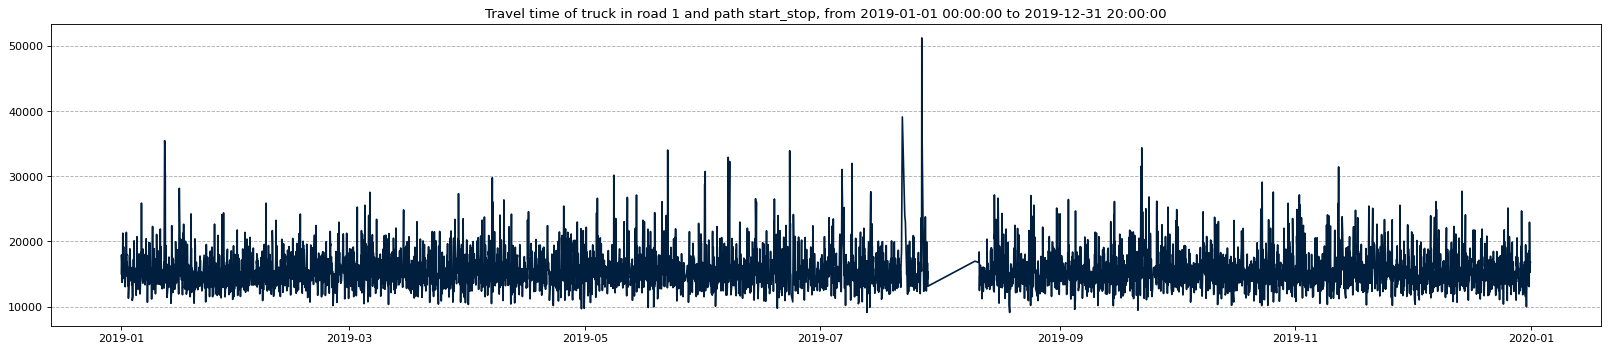

In [839]:

ts, data,date,num_data_points = load_data(filepath, columnName=columnName,plot =True)

# Normalize time series and train test split

In [840]:
# divide training and testing, default as 3:1
def divideTrainTest(dataset,date,num_data_points, rate=0.75,plot=False):

    train_size = int(len(dataset) * rate)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:]

    if plot:
        road = (filepath.split('/')[-1]).split('.')[0]
        path = filepath.split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        

        to_plot_data_y_train[0:train_size] = scaler.inverse_transform(train.reshape(1, -1))
        to_plot_data_y_val[train_size:] = scaler.inverse_transform(test.reshape(1, -1))

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(date, to_plot_data_y_train, label='travel time (train)', color='#3D9970')
        plt.plot(date, to_plot_data_y_val, label='travel time (validation)', color='#0074D9')

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()
    
    return train, test

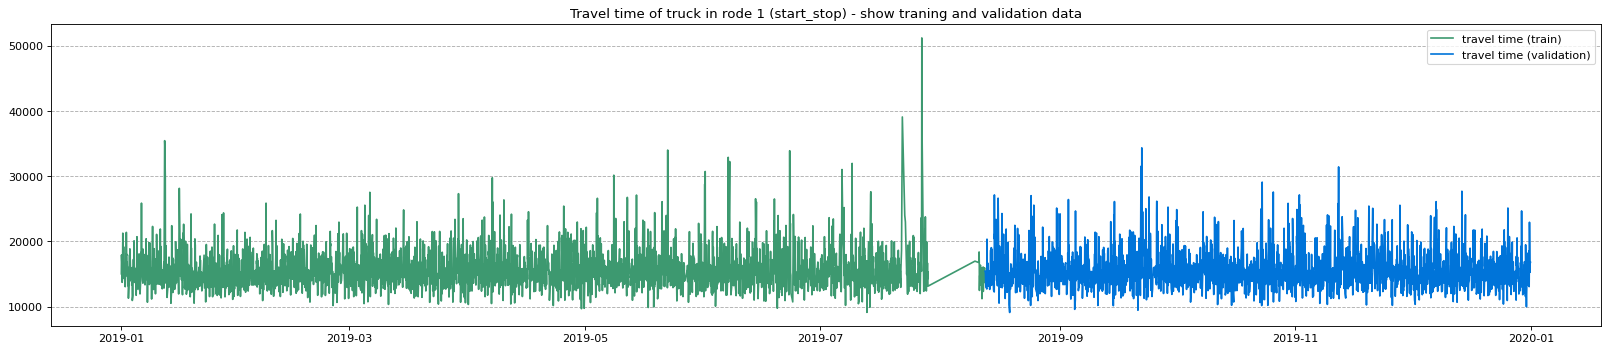

In [841]:
# normalize time series
scaler = StandardScaler() # MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)
# divide the series into training/testing samples
train,test = divideTrainTest(dataset,date,num_data_points,rate=rate,plot=True)


# Create Samples x,y from data

In [842]:
# divide ts as training/testing samples, looBack is lag window
def createSamples(dataset, lookBack):

    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        sample_X = dataset[i:(i + lookBack), :]
        sample_Y = dataset[i + lookBack, :] 
        dataX.append(sample_X)
        dataY.append(sample_Y)
    dataX = np.array(dataX)  # (N, lag, 1)
    dataY = np.array(dataY)  # (N, 1)
    
    dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1]))

    return dataX, dataY

In [843]:
trainX, trainY = createSamples(train, lookBack)
testX, testY = createSamples(test, lookBack)

# SVR Model

In [844]:
def SVR_forecasting(trainX,trainY,testX,testY,C=2.0, epsilon=0.01,gamma = 0.15):

    #find parameter
    # print(gridSearch(trainX, trainY))
    # SVRModel = SVR(C=C, cache_size=200, coef0=0.0, degree=3, epsilon=epsilon, gamma=gamma,
    #                      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
    # SVRModel.fit(trainX, trainY)

    # buil model and train
    SVRModel = SVR.SVRModel(C=C, epsilon=epsilon,gamma=gamma)
    SVRModel.train(trainX, trainY)

    # forecasting
    trainPred = SVRModel.predict(trainX)
    testPred = SVRModel.predict(testX)
    
    # # reverse the time series
    # trainPred = scaler.inverse_transform(trainPred)
    # trainY = scaler.inverse_transform(trainY)
    # testPred = scaler.inverse_transform(testPred)
    # testY = scaler.inverse_transform(testY)
    

    # evaluate
    MAE = calcMAE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred).reshape(-1, 1))
    RMSE = calcRMSE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred).reshape(-1, 1))
    MSE = calcMSE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred).reshape(-1, 1))
    MAPE = calcMAPE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred).reshape(-1, 1))
    SMAPE = calcSMAPE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred).reshape(-1, 1))

    print(f"MSE : {MSE}")
    print(f"RMSE : {RMSE}")
    print(f"MAE : {MAE}")

    
        

    return trainPred,testPred,MSE,RMSE, MAE

def calcRMSE(true,pred):
    return np.sqrt(mean_squared_error(true, pred))

def calcMSE(true,pred):
    return mean_squared_error(true, pred)

def calcMAE(true,pred):
    return mean_absolute_error(true, pred)



def calcMAPE(true, pred, epsion = 0.0000000):

    true += epsion
    return np.sum(np.abs((true-pred)/true))/len(true)*100



def calcSMAPE(true, pred):
    delim = (np.abs(true)+np.abs(pred))/2.0
    return np.sum(np.abs((true-pred)/delim))/len(true)*100

def gridSearch(x,y):
    param_grid ={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001],'kernel':['rbf'],'epsilon':[1,0.1,0.01,0.001],}
    grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=100)
    grid.fit(x,y)
    
    return grid.best_params_
    

In [845]:


def plot(dataset,date,predicted_train,predicted_val,trainY,testY,MSE,RMSE, MAE,rate):
   
    train_size = int(len(dataset) * rate)
    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)
    

    to_plot_data_y_train_pred[lookBack:train_size] = scaler.inverse_transform(predicted_train.reshape(1, -1))
    to_plot_data_y_val_pred[train_size+lookBack:] = scaler.inverse_transform(predicted_val.reshape(1, -1))

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    to_plot_data_y_train = np.zeros(num_data_points)
    to_plot_data_y_val = np.zeros(num_data_points)
        

    to_plot_data_y_train[lookBack:train_size] = scaler.inverse_transform(trainY.reshape(1, -1))
    to_plot_data_y_val[train_size+lookBack:] = scaler.inverse_transform(testY.reshape(1, -1))

    to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

    # plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(date, to_plot_data_y_train, label='Actual travel time', color='#001f3f')
    plt.plot(date, to_plot_data_y_val, label='Actual travel time', color='#001f3f')
    plt.plot(date, to_plot_data_y_train_pred, label='Predicted travel time (train)', color='#3D9970')
    plt.plot(date, to_plot_data_y_val_pred, label='Predicted travel time (validation)', color='#0074D9')
    plt.title(f"Compare predicted travel time to actual travel time")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(testY.reshape(-1, 1))
    to_plot_predicted_val = scaler.inverse_transform(predicted_val.reshape(-1, 1))
    to_plot_data_date = date[train_size+lookBack:]

    #plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label='Actual travel time', color='#001f3f')
    plt.plot(to_plot_data_date, to_plot_predicted_val, label='Predicted travel time (validation)', color='#0074D9')
    plt.title(f"Zoom in to examine predicted travel time on validation data portion [MSE: {MSE:.3f} | RMSE: {RMSE:.3f} | MAE: {MAE:.3f}]")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

# Model Training

In [846]:
#trainPred, testPred,MSE,RMSE, MAE = SVR_forecasting(trainX, trainY, testX, testY, C=C, epsilon=epsilon,gamma = gamma)
#plot(data,date,trainPred,testPred,testY,MSE,RMSE, MAE,rate)

In [847]:
# predict road
filepath_road1 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/1.csv"
filepath_road2 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/2.csv"
filepath_road4 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/4.csv"
filepath_road7 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/7.csv"
filepath_road9 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/9.csv"
filepath_road32 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/32.csv"
filepath_road35 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/35.csv"
filepath_road41 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/41.csv"
filepath_road304 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/304.csv"
filepath_road331 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/331.csv"

def predictTime(filepath):
    ts, data,date,num_data_points = load_data(filepath, columnName=columnName,plot =False)
    # normalize time series
    scaler = StandardScaler() # MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # divide the series into training/testing samples
    train,test = divideTrainTest(dataset,date,num_data_points,rate=rate,plot=False)
    trainX, trainY = createSamples(train, lookBack)
    testX, testY = createSamples(test, lookBack)
    trainPred, testPred,MSE,RMSE, MAE = SVR_forecasting(trainX, trainY, testX, testY, C=C, epsilon=epsilon,gamma = gamma)
    road = (filepath.split('/')[-1]).split('.')[0]
    path = filepath.split('/')[-2]
            
    print("Travel time of truck in road : "+road)
    plot(data,date,trainPred,testPred,trainY,testY,MSE,RMSE, MAE,rate)


time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 7194811.456113635
RMSE : 2682.3145706858536
MAE : 1950.9765061208361
Travel time of truck in road : 1


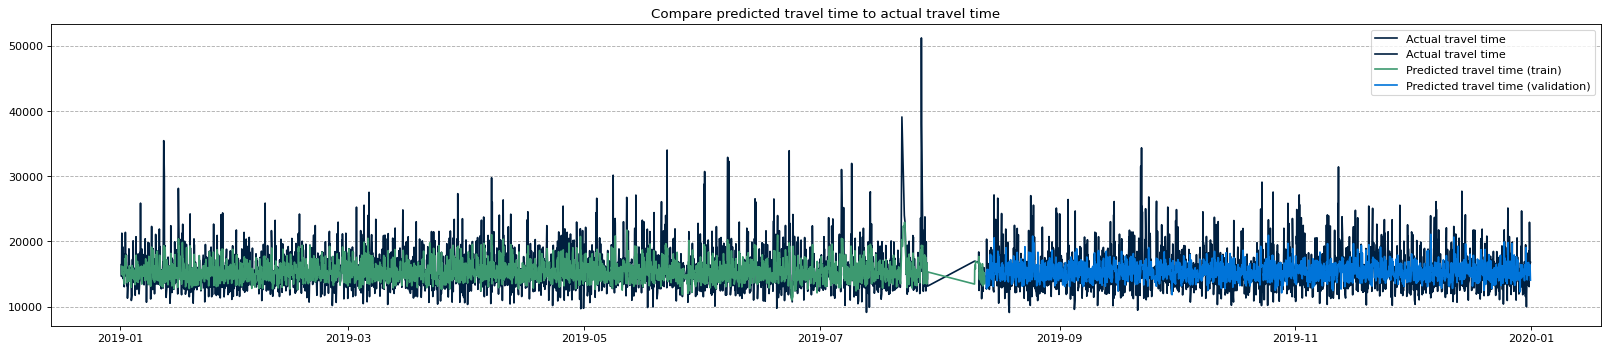

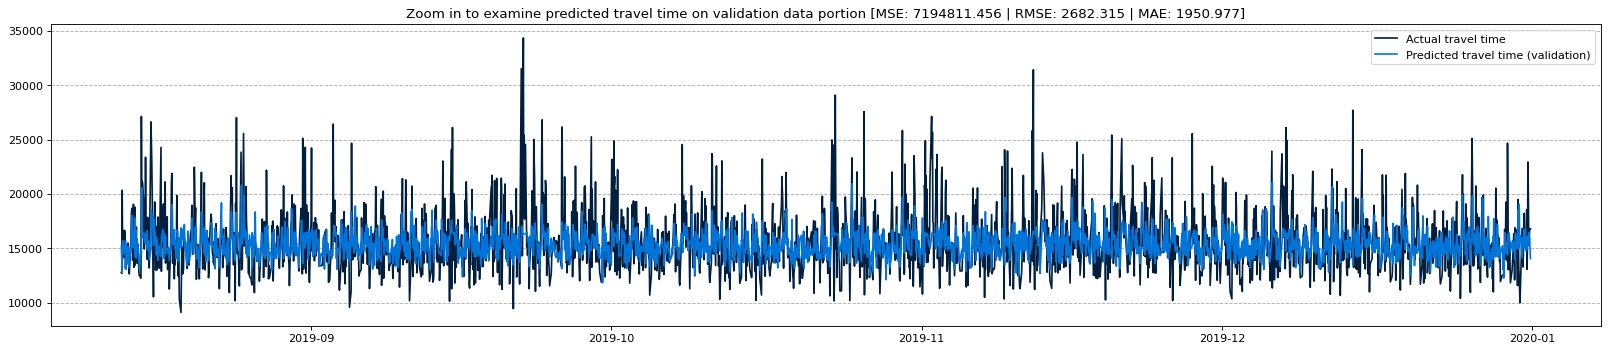

In [848]:
predictTime(filepath_road1)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 7207100.712510065
RMSE : 2684.604386592197
MAE : 1891.2133993483662
Travel time of truck in road : 2


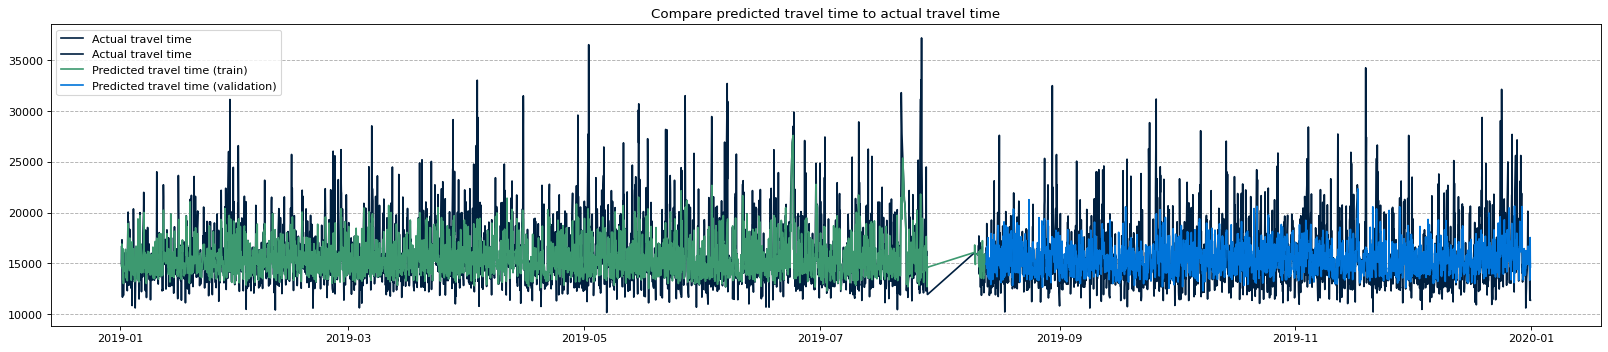

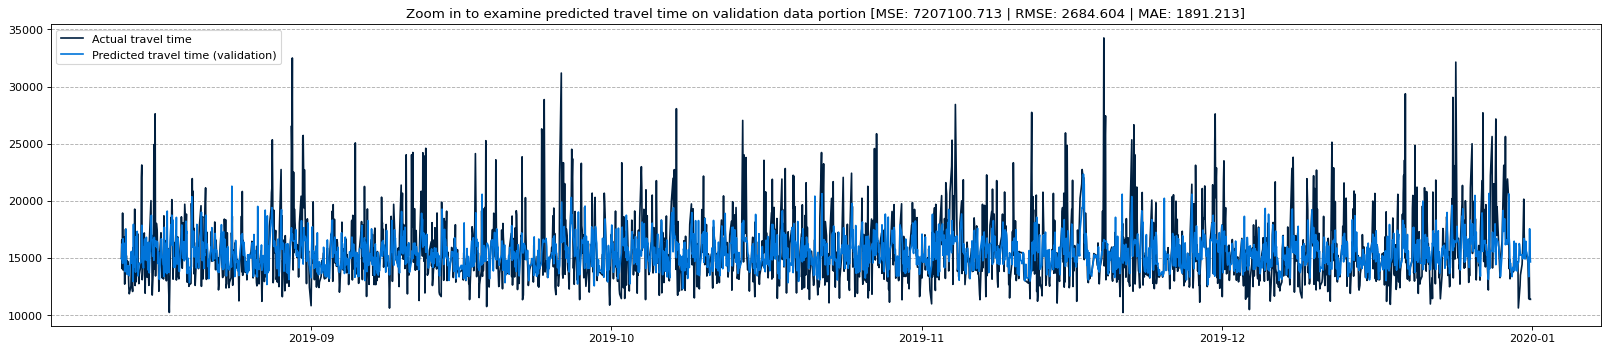

In [849]:
predictTime(filepath_road2)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 7198130.770785677
RMSE : 2682.9332400910907
MAE : 1976.3591312301457
Travel time of truck in road : 4


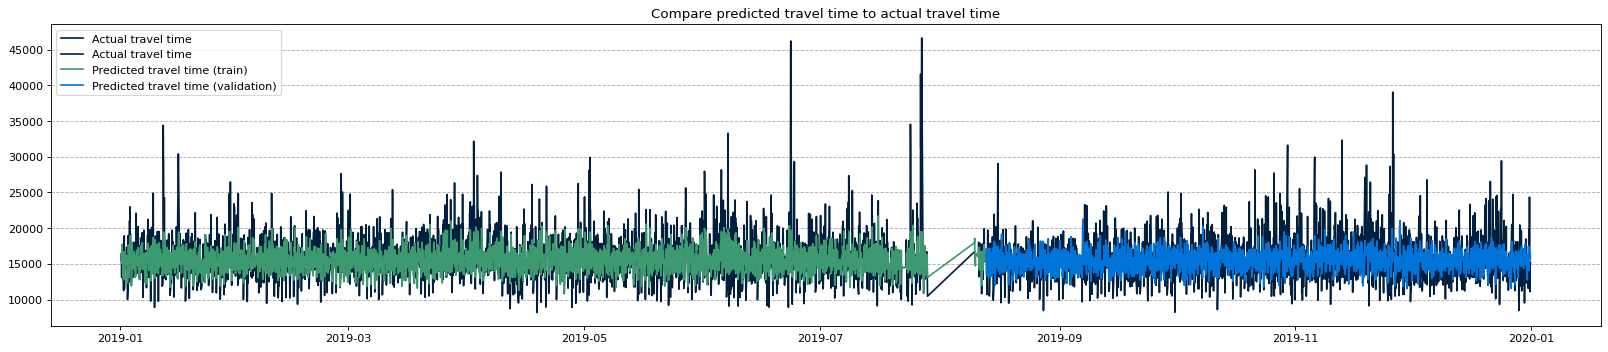

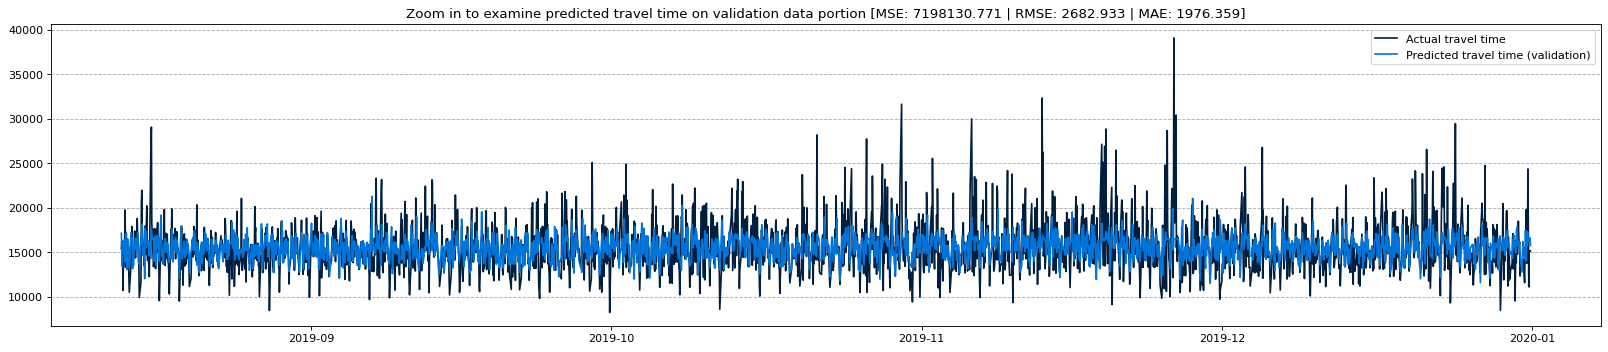

In [850]:
predictTime(filepath_road4)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 7069636.432507667
RMSE : 2658.8787923686305
MAE : 1967.148895114078
Travel time of truck in road : 7


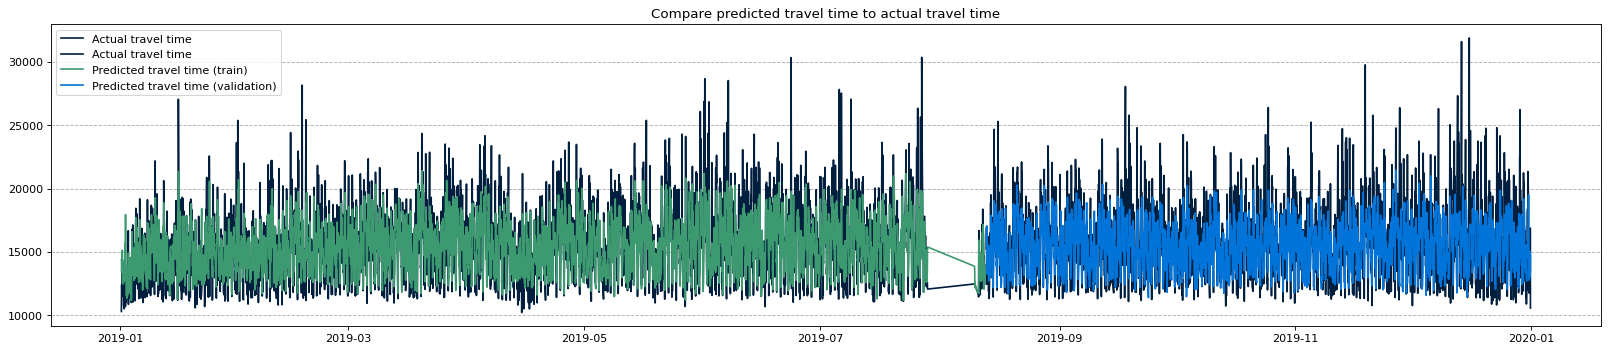

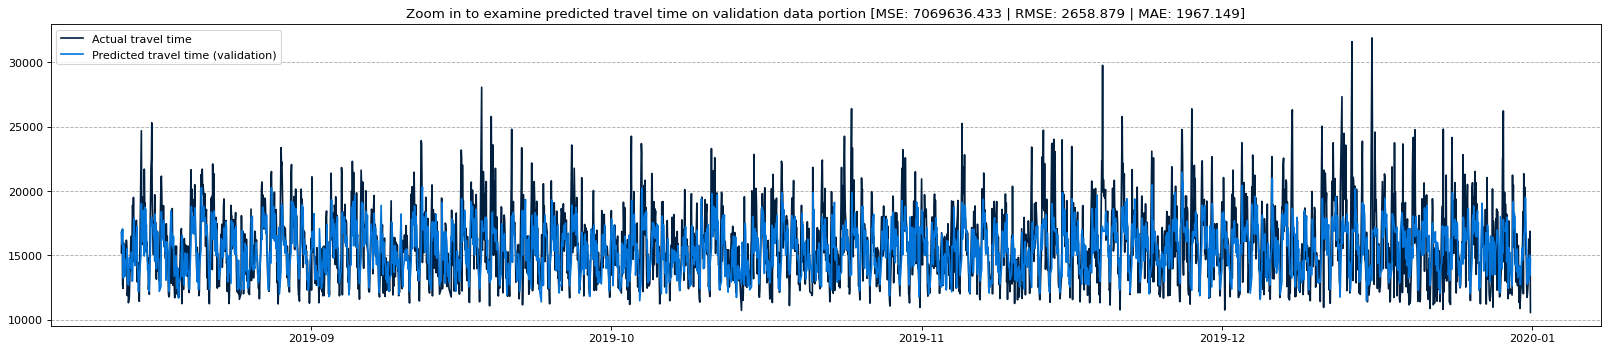

In [851]:
predictTime(filepath_road7)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 9682420.296628878
RMSE : 3111.658769310812
MAE : 1989.7720079268618
Travel time of truck in road : 9


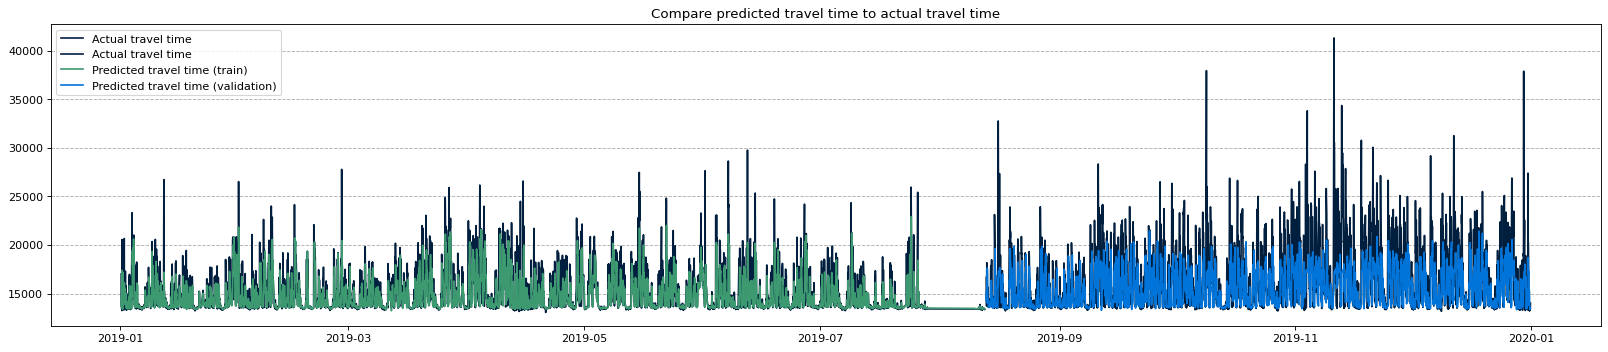

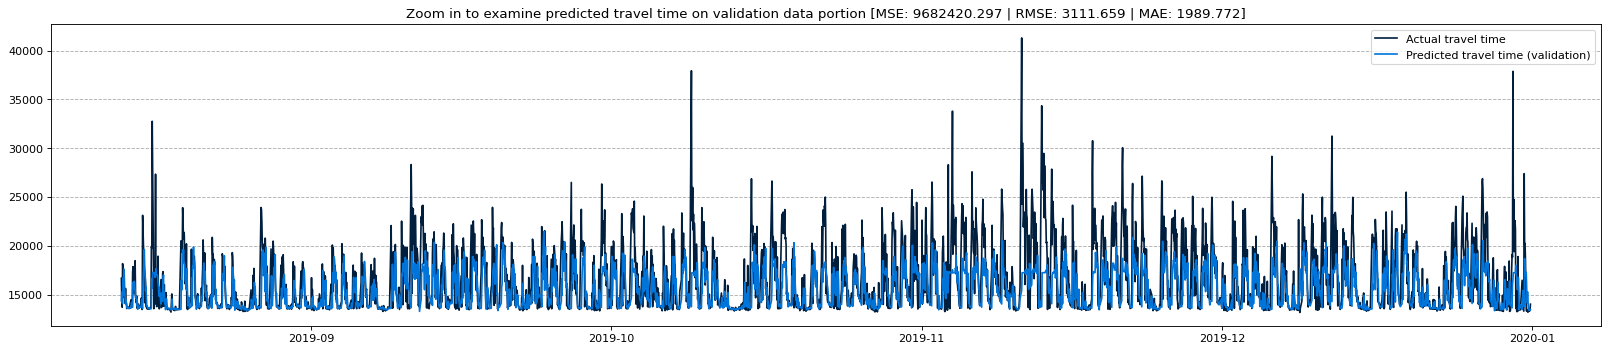

In [852]:
predictTime(filepath_road9)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 9909284.281018218
RMSE : 3147.901567873147
MAE : 1531.6255709560141
Travel time of truck in road : 32


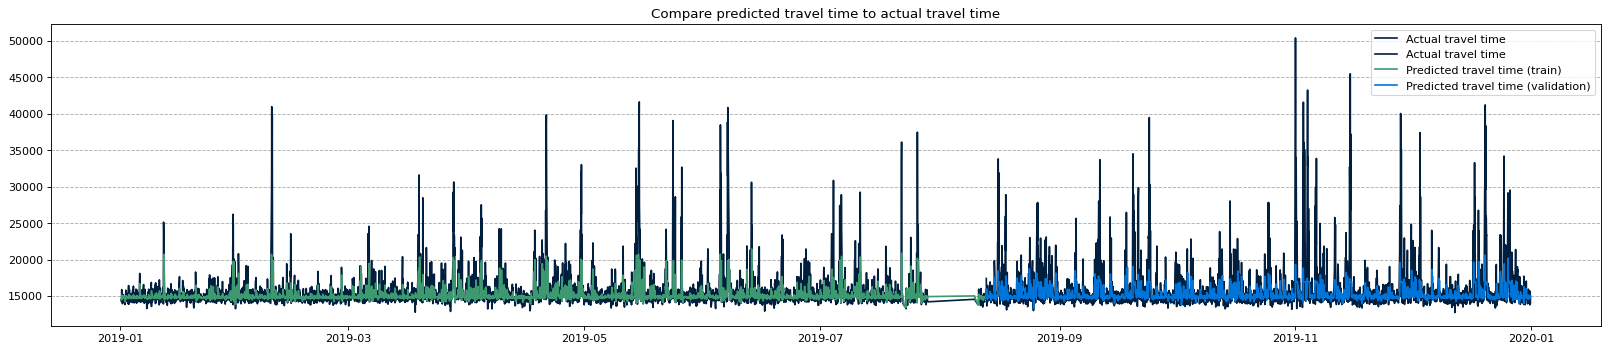

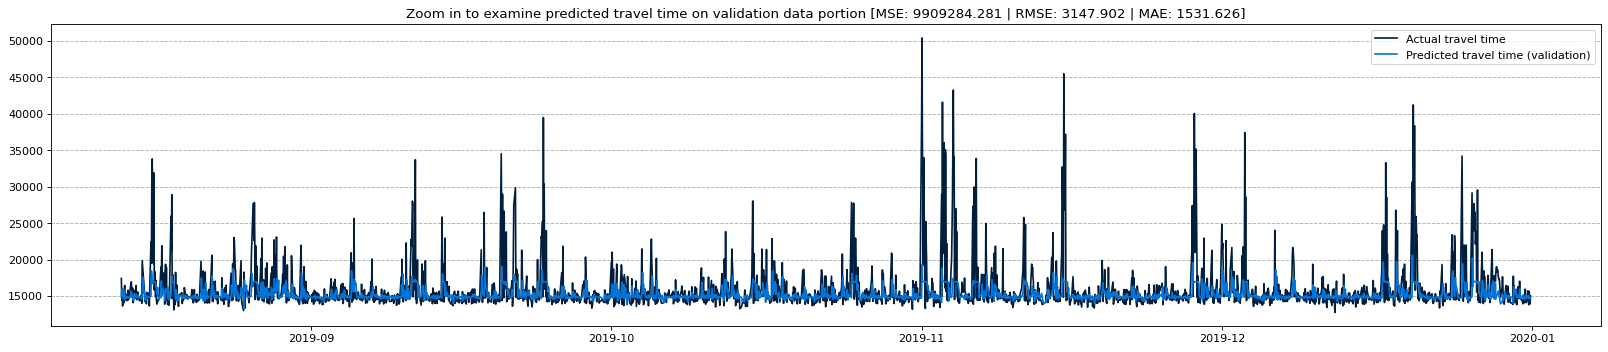

In [853]:
predictTime(filepath_road32)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 7850519.42906523
RMSE : 2801.877839782675
MAE : 1789.4881939294087
Travel time of truck in road : 35


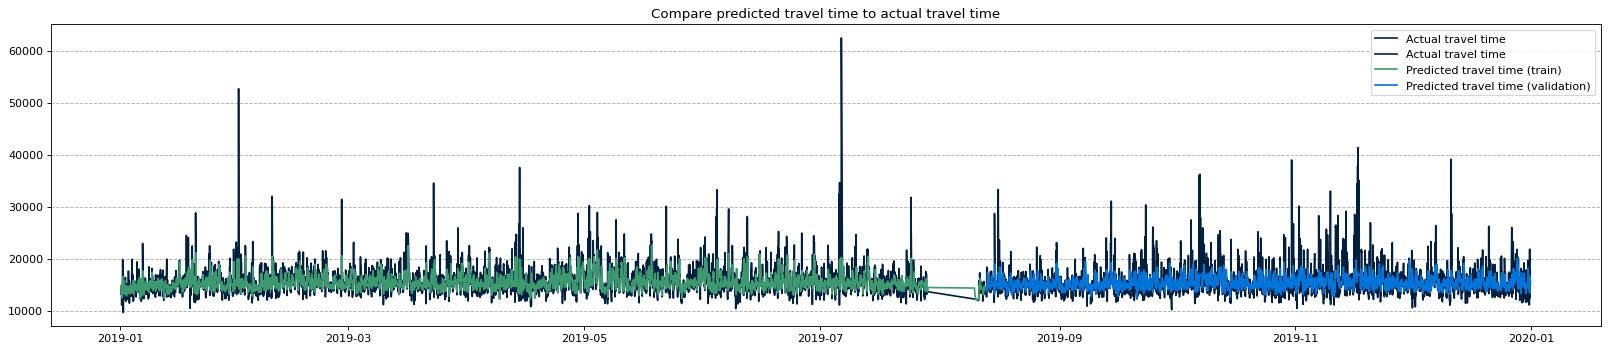

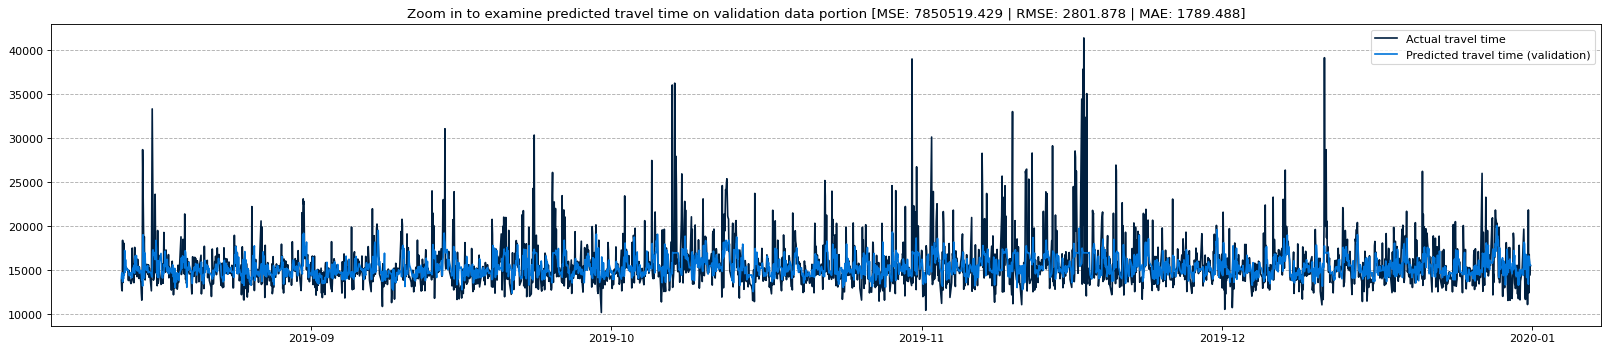

In [854]:
predictTime(filepath_road35)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 6221032.110795195
RMSE : 2494.1996934478193
MAE : 1657.6082238924687
Travel time of truck in road : 41


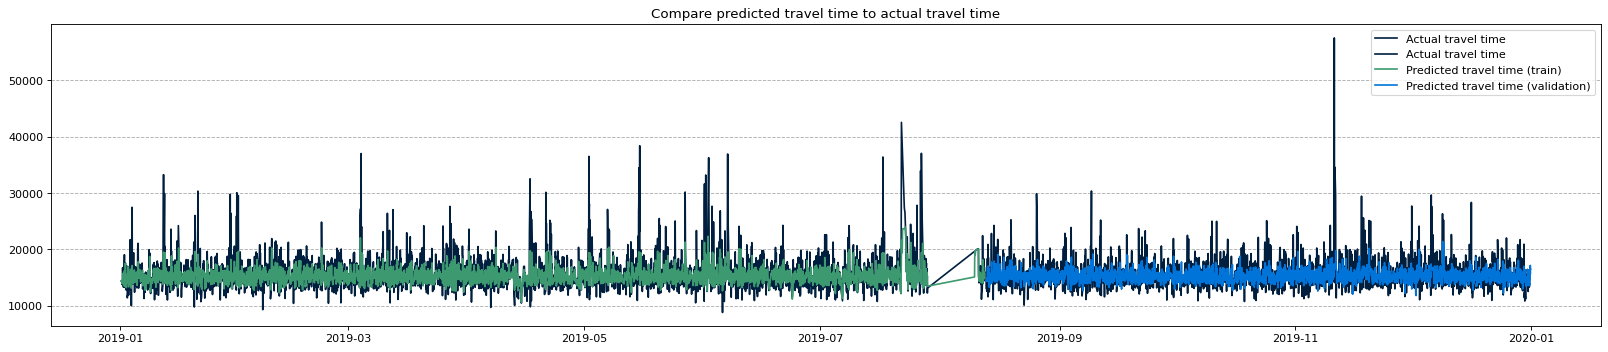

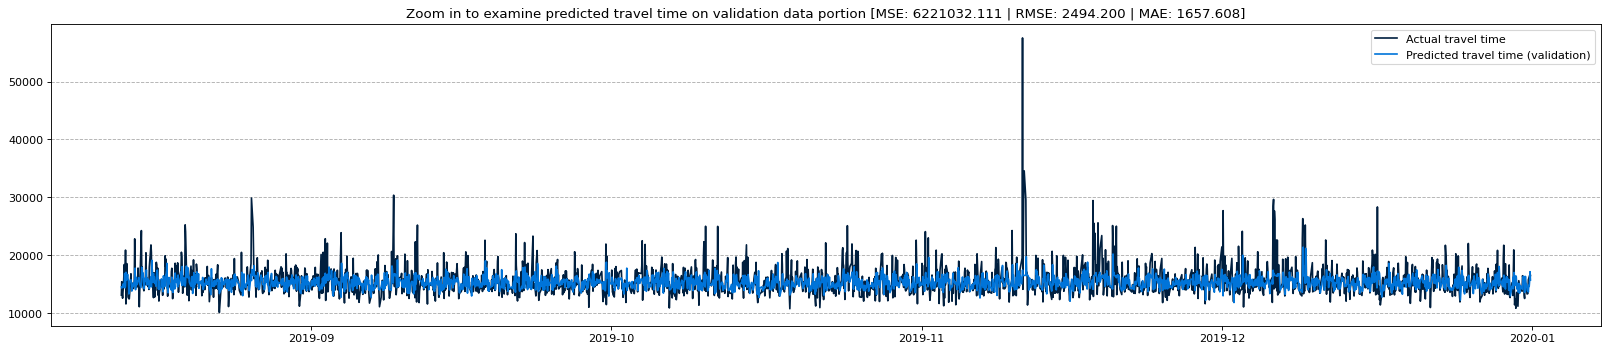

In [855]:
predictTime(filepath_road41)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 10794791.957572877
RMSE : 3285.5428710599526
MAE : 1763.707200137859
Travel time of truck in road : 304


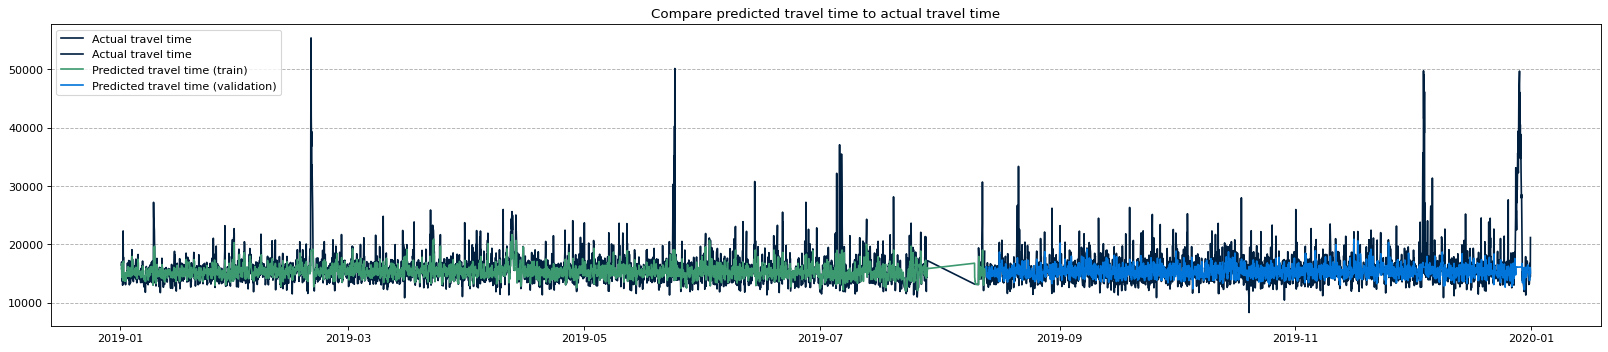

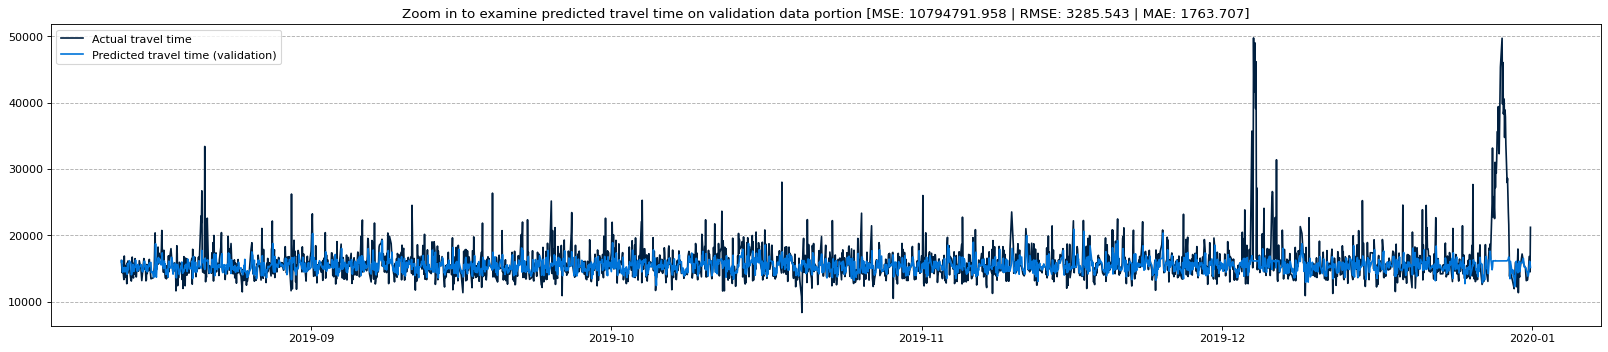

In [856]:
predictTime(filepath_road304)

time series shape: (7413, 1)


C:\Users\Nirachaa\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE : 11784237.447127432
RMSE : 3432.817712481604
MAE : 2017.0724799860136
Travel time of truck in road : 331


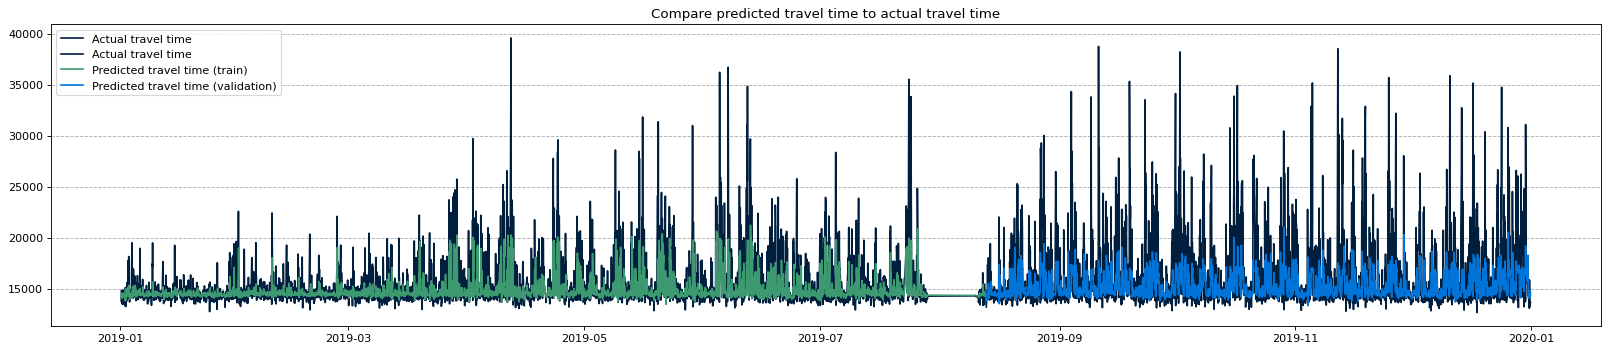

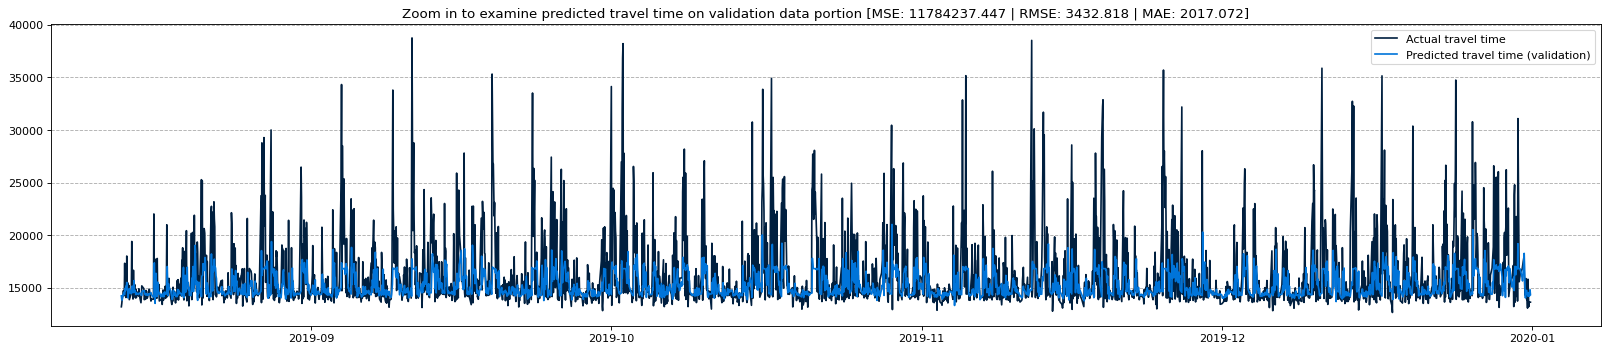

In [857]:
predictTime(filepath_road331)